# Surface Crack Images - OLeNet model
This notebook contains the code training the OLeNet model with ReLU (without augmented data)

**Load packages/modules**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import time
import torch
import torchvision

from torchvision import datasets, transforms

print(f'Torch version: {torch .__version__}')

Torch version: 1.10.0+cu111


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid

%pip install torchsummary

from torchvision import models
from torchsummary import summary

**Load data into tensors first**<br>
Then concatenate the tensors with original and augmented data into one for ease of model training

In [6]:
# load data into tensors first
data_dir = '/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/data/archive/original'
# aug_data_dir = '/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/data/archive/augmented'
batch_size = 64 

transform = transforms.Compose([transforms.ToTensor()])

data = datasets.ImageFolder(data_dir, transform=transform)

dataloader = torch.utils.data.DataLoader(data, 
                                         batch_size=batch_size,
                                         shuffle=True, 
                                         pin_memory=True)

# aug_dataloader = torch.utils.data.DataLoader(aug_data,
#                                              batch_size=batch_size*9,  # multiply by 9 since augmented x9 images for each original
#                                              shuffle=True,
#                                              pin_memory=True)

# images, labels = next(iter(dataloader))
# aug_images, aug_labels = next(iter(aug_dataloader))

# print(f'Original images shape: {images.shape}')
# print(f'Augmented images shape: {aug_images.shape}')

In [ ]:
# generate and save test set
test_counter = 1
for i, data in enumerate(dataloader, 0):
    if i+1 > 500:
        if test_counter == 1:
            test_inputs, test_labels = data 
            test_counter += 1
        else:
            new_inputs, new_labels = data
            test_inputs = torch.concat((test_inputs, new_inputs), 0)
            test_labels = torch.concat((test_labels, new_labels), 0)
            test_counter += 1

        # print(f'Batch {i+1} for test set complete.')
    else:
        continue

# print(f'Saving test inputs {test_inputs.shape}, test labels {test_labels.shape}')

# save test set at the end of training
testset = [test_inputs, test_labels]
path = f"/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/LeNet5_model_saves/00_tanh_lr0.001/lenet5_lr0.001_testset.pth"
torch.save(testset, path)

Check labels and images

images.shape: torch.Size([5, 3, 227, 227])
Labels: tensor([0, 1, 0, 0, 1])


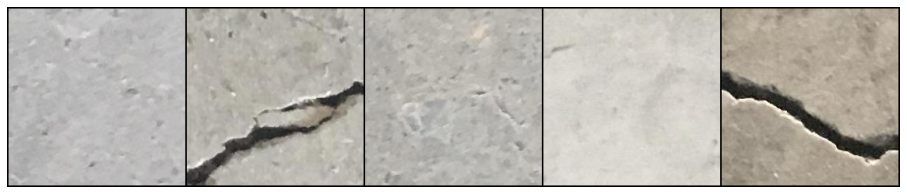

In [ ]:
# check labels in original images (using batch size=5 in dataloader)
'''
Label 0 = no surface crack
Label 1 = has surface crack
'''

print('images.shape:', images.shape)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(make_grid(images, nrow=5).permute((1, 2, 0)))
    
print(f'Labels: {labels}')

aug_images.shape: torch.Size([5, 3, 227, 227])
Labels: tensor([0, 1, 0, 1, 0])


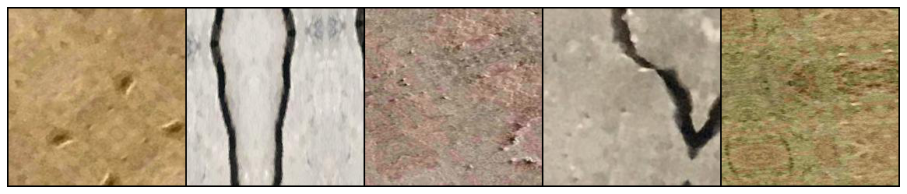

In [ ]:
# check labels in augmented images (using batch size of 5 in dataloader)
'''
Label 0 = no surface crack
Label 1 = has surface crack
'''

print('aug_images.shape:', aug_images.shape)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(make_grid(aug_images, nrow=5).permute((1, 2, 0)))
    
print(f'Labels: {aug_labels}')

# Construct model
**OLeNet model architecture:** <br>
 Conv2D - 50 x 50 x 32 <br>
 Conv2D - 50 x 50 x 32 <br>
 MaxPool2D - 25 x 25 x 32 <br>
 Drop - 25 x 25 x 32 <br>
 
 Conv2D - 50 x 50 x 64 <br>
 Conv2D - 50 x 50 x 64 <br>
 MaxPool2D - 12 x 12 x 64 <br>
 Drop - 12 x 12 x 64 <br>

 Flatten (9216) <br>
 Dense (256) <br>
 Drop (256) <br>
 Dense (2)

In [7]:
class OLeNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, 5, padding=2, stride=2)
        self.conv4 = nn.Conv2d(64, 64, 5, padding=2, stride=2)

        # fully connected layers
        self.fc1 = nn.Linear(64*3*3, 256)
        self.fc2 = nn.Linear(256, 2)   # have two classes (has crack/no crack)
        
        # softmax layer
        self.softmax = nn.Softmax(dim=1)
        
        # pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)  # Max pool 2x2

        # dropout layer
        self.drop = nn.Dropout(p=0.5) # drop out with probability of 0.5

    def forward(self,x):

        x = F.relu(self.conv1(x)) # layer 1
        x = F.relu(self.conv2(x)) # layer 2
        x = self.pool(x)          # pool layer
        x = self.drop(x)          # dropout layer
        
        x = F.relu(self.conv3(x)) # layer 5
        x = F.relu(self.conv4(x)) # layer 6
        x = self.pool(x)          # pool layer
        x = self.drop(x)          # dropout layer
        
        x = torch.flatten(x, 1)   # flatten layer
        
        x = F.relu(self.fc1(x))   # layer 7
        x = self.drop(x)          # dropout layer
        logit = self.fc2(x)       # layer 
        
        output = self.softmax(logit) # output layer

        return logit, output

In [ ]:
# print model summary

model = OLeNet()

channels = 3
H = 227
W = 227

summary(model, (channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 114, 114]           2,432
            Conv2d-2           [-1, 32, 57, 57]          25,632
         MaxPool2d-3           [-1, 32, 28, 28]               0
           Dropout-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 64, 14, 14]          51,264
            Conv2d-6             [-1, 64, 7, 7]         102,464
         MaxPool2d-7             [-1, 64, 3, 3]               0
           Dropout-8             [-1, 64, 3, 3]               0
            Linear-9                  [-1, 256]         147,712
          Dropout-10                  [-1, 256]               0
           Linear-11                    [-1, 2]             514
          Softmax-12                    [-1, 2]               0
Total params: 330,018
Trainable params: 330,018
Non-trainable params: 0
-------------------------------

### Train model

In [ ]:
# for timing model training purposes
start_time = time.time()

# input variables
epoch_num = 10
learning_rate = 0.001

# train model
model = OLeNet()
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# to store loss for training & validation set
jw_train_epoch = []  ## to store loss for training set by epoch (average loss of iterations)
jw_val_epoch = []    ## to store loss for validation set by epoch (average loss of iterations)

# to store accuracy of training & validation set
acc_train_epoch = []
acc_val_epoch = []

for epoch in range(epoch_num):

    # track train & validation loss & accuracy by iteration for each epoch
    train_loss = []
    train_acc = []

    val_loss = []
    val_acc = []

    test_counter = 1

    for i, data in enumerate(dataloader, 0):

        ''' include below IF statement if want to limit number of batches '''
        if i+1 == 501:  # should have total of 500 batches after train & val sets
            break
        
        # use 80% for training, 20% for testing, and 10% for validation of the 40k training samples
        ## batch size=64 so 625 batches total: 450 train batches, 50 val batches, and 125 test batches

        if i+1 > 450:  # validate model with validation set (10% of total train data)
            inputs, labels = data
            
            logits, outputs = model(inputs)
            cost = cost_fn(logits, labels)
            
            jw_val = float(cost)

            # calculate accuracy
            pred = torch.Tensor.argmax(outputs, dim=1)
            correct = pred == labels
            acc = sum(np.array(correct))/len(np.array(correct))

            acc_val = acc

            val_loss.append(jw_val)
            val_acc.append(acc_val)
            
            print(f'Validation iteration {i+1} loss: {jw_val}, ACC: {acc_val}')
            
        else:  # train model with training set

            inputs, labels = data

            optimizer.zero_grad()            # zero the parameter gradients
            logits, outputs = model(inputs)  # forward
            cost = cost_fn(logits, labels)   # input logits prior to softmax activation into cost function
            cost.backward()                  # backward
            optimizer.step()                 # optimize

            jw_train = float(cost)

            # calculate accuracy
            pred = torch.Tensor.argmax(outputs, dim=1)            # get labels of prediction with highest probability
            correct = pred == labels                              # compare to actual labels and see which was predicted correctly

            acc = sum(np.array(correct))/len(np.array(correct))   # calculate accuracy

            acc_train = acc

            train_loss.append(jw_train)
            train_acc.append(acc_train)
            
            print(f'Training iteration {i+1} loss: {jw_train}, ACC:{acc_train}')

    # to save time, epoch loss = the lowest loss, epoch acc = highest acc in training
    epoch_jw = np.mean(np.array(train_loss))
    epoch_acc = np.mean(np.array(train_acc))

    jw_train_epoch.append(epoch_jw)
    jw_val_epoch.append(np.mean(val_loss))
    acc_train_epoch.append(epoch_acc)
    acc_val_epoch.append(np.mean(val_acc))
    
    print(f'-- Epoch {epoch+1} done -- Train loss: {epoch_jw}, train ACC: {epoch_acc}, val loss: {np.mean(val_loss)}, val ACC: {np.mean(val_acc)}')
    
    print("<--- %s seconds --->" % (time.time() - start_time))

    # save model at every epoch
    path = f"/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/OLeNet_model_saves/00_relu_lr0.001/olenet_lr0.001_cpu_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), path)


Streaming output truncated to the last 5000 lines.
Training iteration 21 loss: 0.7005048990249634, ACC:0.40625
Training iteration 22 loss: 0.6990957260131836, ACC:0.40625
Training iteration 23 loss: 0.7038742303848267, ACC:0.359375
Training iteration 24 loss: 0.69583660364151, ACC:0.53125
Training iteration 25 loss: 0.683174192905426, ACC:0.640625
Training iteration 26 loss: 0.6889878511428833, ACC:0.578125
Training iteration 27 loss: 0.6991180777549744, ACC:0.390625
Training iteration 28 loss: 0.6910980343818665, ACC:0.5625
Training iteration 29 loss: 0.6895067691802979, ACC:0.546875
Training iteration 30 loss: 0.6836745142936707, ACC:0.59375
Training iteration 31 loss: 0.6822362542152405, ACC:0.53125
Training iteration 32 loss: 0.6839014887809753, ACC:0.640625
Training iteration 33 loss: 0.6749911904335022, ACC:0.625
Training iteration 34 loss: 0.7088664174079895, ACC:0.4375
Training iteration 35 loss: 0.6343264579772949, ACC:0.59375
Training iteration 36 loss: 0.6618523597717285, AC

Plot loss and accuracy over epochs

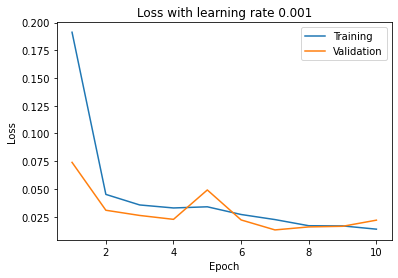

In [ ]:
# plot loss over epoch
plt.plot([i+1 for i in range(len(jw_train_epoch))],jw_train_epoch)
plt.plot([i+1 for i in range(len(jw_val_epoch))],jw_val_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss with learning rate {learning_rate}')
plt.legend(['Training','Validation'])
plt.show()

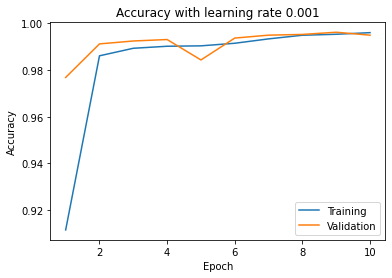

In [ ]:
# plot accuracy over epoch
plt.plot([i+1 for i in range(len(acc_train_epoch))],acc_train_epoch)
plt.plot([i+1 for i in range(len(acc_val_epoch))],acc_val_epoch)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy with learning rate {learning_rate}')
plt.legend(['Training','Validation'])
plt.show()

**Calculate test accuracy for model**

In [9]:
# load saved model 
path = f"/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/OLeNet_model_saves/00_relu_lr0.001/olenet_lr0.001_cpu_epoch{7}.pth"

model = OLeNet()
model.load_state_dict(torch.load(path))
print(model.eval())

# or use model in current session
# model = model

# calculate test accuracy of model at a given epoch

correct_counter = 0
data_counter = 0

for i, data in enumerate(dataloader, 0):
  if i+1 > 125:  # should have a total of 125 batches for test set
      break
  else:
      inputs, labels = data
      logits, outputs = model(inputs)

      # calculate overall accuracy across all classes
      pred = torch.Tensor.argmax(outputs, dim=1)
      correct = pred == labels

      correct_cnt = sum(np.array(correct))
      data_cnt = len(np.array(correct))

      correct_counter += correct_cnt 
      data_counter += data_cnt

      print(f'\n Batch {i+1} testing ACC = {(correct_counter/data_counter)*100:.1f}%')

OLeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
)

 Batch 1 testing ACC = 100.0%

 Batch 2 testing ACC = 100.0%

 Batch 3 testing ACC = 100.0%

 Batch 4 testing ACC = 100.0%

 Batch 5 testing ACC = 100.0%

 Batch 6 testing ACC = 100.0%

 Batch 7 testing ACC = 100.0%

 Batch 8 testing ACC = 100.0%

 Batch 9 testing ACC = 100.0%

 Batch 10 testing ACC = 100.0%

 Batch 11 testing ACC = 100.0%

 Batch 12 testing ACC = 100.0%

 Batch 13 testing ACC = 100.0%



In [ ]:
# test accuracy with 1000 augmented images to see if model can handle "new" inputs

# load saved model 
path = f"/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/OLeNet_model_saves/00_relu_lr0.001/olenet_lr0.001_cpu_epoch{7}.pth"

model = OLeNet()
model.load_state_dict(torch.load(path))
print(model.eval())

# or use model in current session
# model = model

# calculate test accuracy of model at a given epoch

testset_path = f"/content/drive/MyDrive/SJSU MSDA/Fall 2021/DATA 255/Project/Code/data/test_sets/small_1000_set.pth"
inputs, labels = torch.load(testset_path)

logits, outputs = model(inputs)

# calculate overall accuracy across all classes
pred = torch.Tensor.argmax(outputs, dim=1)
correct = pred == labels

correct_cnt = sum(np.array(correct))
data_cnt = len(np.array(correct))

print(f'\n Testing accuracy = {(correct_cnt/data_cnt)*100:.1f}%')

OLeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
)

 Testing accuracy = 87.8%
